# Extracting relevant information to construct seed values for linear mixing endmember spectra

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [4]:
data = np.loadtxt("../data/RaCA-spectra-raw.txt",
                 delimiter=",", dtype=str)

In [7]:
data[0,2152:]
sample_top   = data[1:,2153].astype('float32')
sample_bot   = data[1:,2154].astype('float32')
sample_txtr  = data[1:,2156]
sample_bd    = data[1:,2158].astype('float32')
sample_bdsd  = data[1:,2159].astype('float32')
sample_soc   = data[1:,2162].astype('float32')
sample_socsd = data[1:,2163].astype('float32')

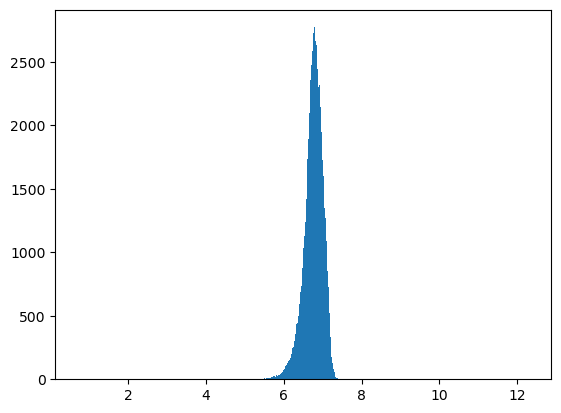

In [35]:
I = data[1:,1:2152].astype('float32')
plt.hist(np.log(np.sum(I,axis=1)),bins='auto');
I = (I.T/np.sum(I,axis=1)).T
XF = np.array([x for x in range(350,2501)]);

### Summarial Statistics: Means, variances, difference distributions

(0.0, 0.002)

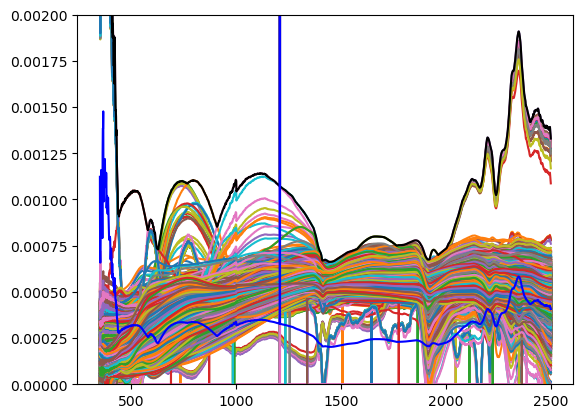

In [27]:
plt.plot(XF,I.T);
plt.plot(XF,np.max(I,axis=0),'black');
plt.plot(XF,np.max(I,axis=0)/np.sum(np.max(I,axis=0)),'blue');
plt.ylim([0,0.002])

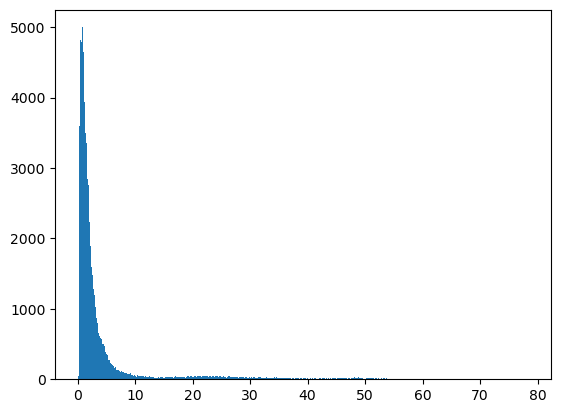

In [8]:
plt.hist(sample_soc,bins='auto');

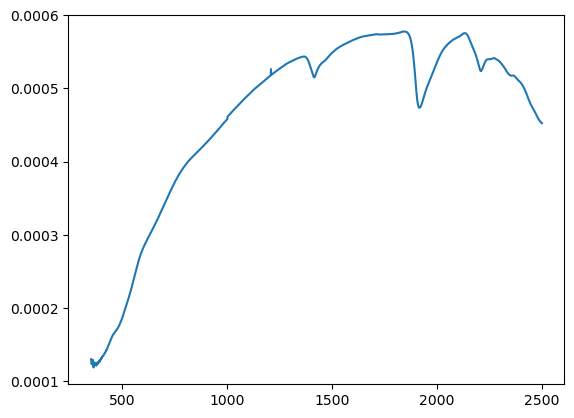

In [25]:
plt.plot(XF,np.mean(I.T,axis=1))

In [ ]:
plt.plot(XF,np.mean(I.T,axis=1))

(0.0, 8e-09)

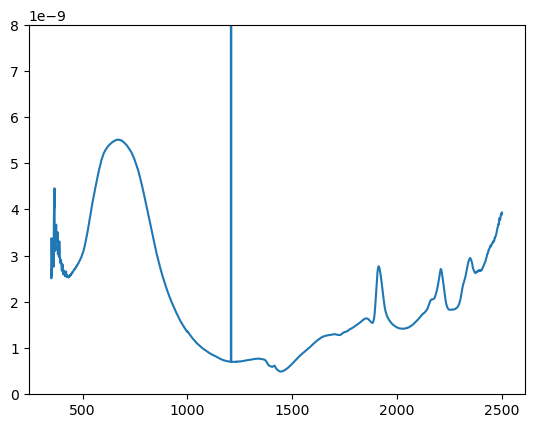

In [24]:
plt.plot(XF,np.var(I.T,axis=1))
plt.ylim([0,0.000000008])

(0.0, 4e-05)

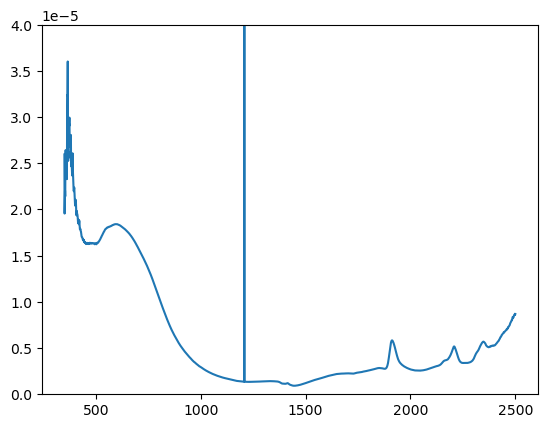

In [19]:
plt.plot(XF,np.var(I.T,axis=1)/np.mean(I.T,axis=1))
plt.ylim([0,0.00004])

In [15]:
def get_quantile_diff_dist_fast(tI) :
    return np.abs(I - I[:,np.newaxis]).reshape([I.shape[0] ** 2,I.shape[1]])

def get_quantile_diff_dist(tI, q) :
    NN = tI.shape[0]
    diffs = np.zeros([int(NN*(NN-1)/2),tI.shape[1]])
    
    ind=0
    for i in range(NN) :
        for j in range(i) :
            diffs[ind,:] = np.abs(tI[i,:] - tI[j,:])
            ind+=1
            
    print(diffs.shape)
    
    return np.quantile(diffs, q, axis=0)

diff_dist = get_quantile_diff_dist_fast(I);
vlamb68 = np.quantile(diff_dist, 0.68, axis=0) # 1 sigma
vlamb95 = np.quantile(diff_dist, 0.95, axis=0) # 2 sigma
vlamb99 = np.quantile(diff_dist, 0.99, axis=0) # 3 sigma

sandplot_y = [np.mean(I,axis=0) - vlamb99, vlamb99 - vlamb95, vlamb95 - vlamb68, 2.0*vlamb68, vlamb95 - vlamb68, vlamb99 - vlamb95]

COLORS = ["#FFFFFF", "#C6DDFB", "#74A9CF", "#045A8D", "#74A9CF", "#C6DDFB"]
fig, ax = plt.subplots(figsize=(10, 7))
ax.stackplot(XF, sandplot_y, colors=COLORS, baseline="zero", labels=[None,'3$\sigma$ Band','2$\sigma$ Band','1$\sigma$ Band']);
plt.plot(XF, np.mean(I, axis=0), 'black')

plt.ylabel('Reflectance [AU]',fontsize=16)
plt.xlabel('Wavelength [nm]',fontsize=16)

ax.set_title('Band difference distributions', fontsize=18)
plt.legend(loc='upper left')
plt.show()

MemoryError: Unable to allocate 115. TiB for an array with shape (121376, 121376, 2151) and data type float32

### Correlations between soil variables and spectral lines

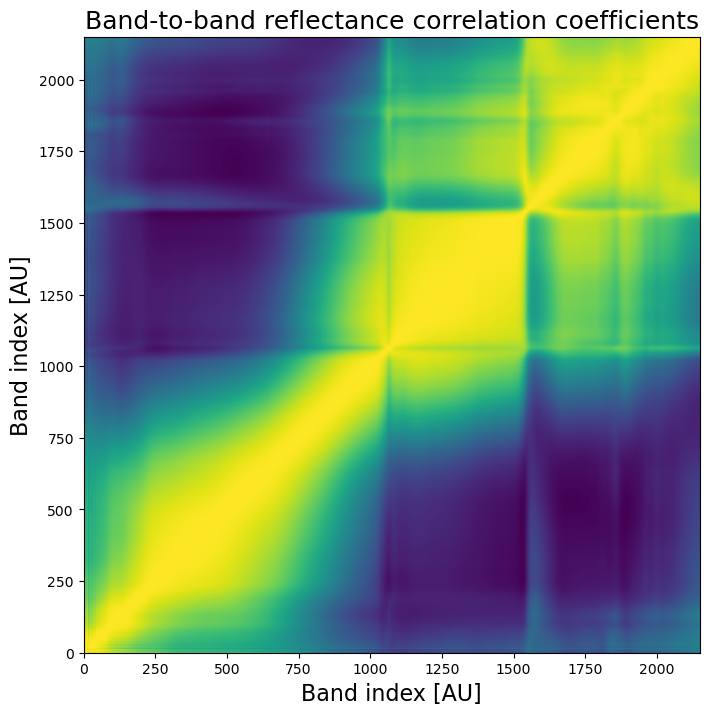

In [13]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.corrcoef(I, I, rowvar = False),interpolation='none')

plt.ylabel('Band index [AU]',fontsize=16)
plt.xlabel('Band index [AU]',fontsize=16)

ax.set_title('Band-to-band reflectance correlation coefficients', fontsize=18)

plt.xlim([0,2150])
plt.ylim([0,2150])

plt.show()

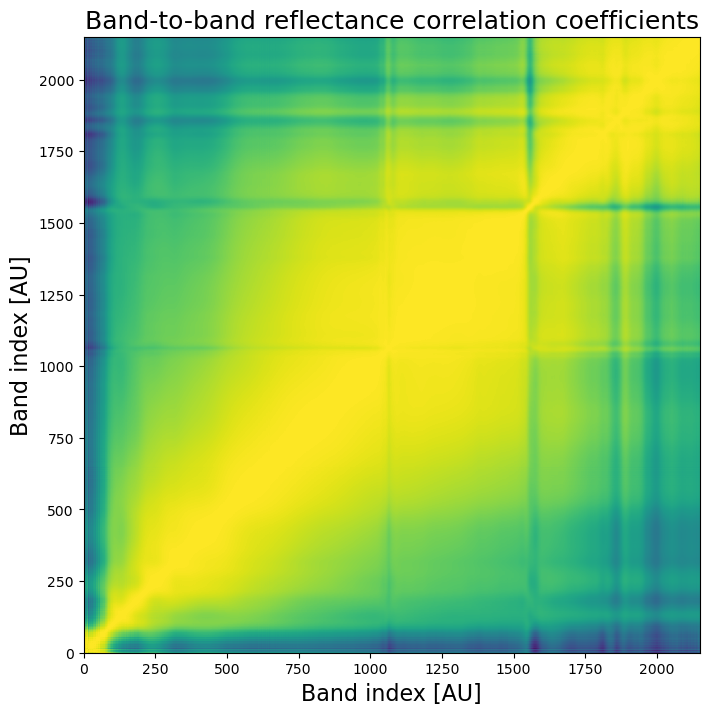

In [36]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.corrcoef(data[1:,1:2152].astype('float32'), data[1:,1:2152].astype('float32'), rowvar = False),interpolation='none')

plt.ylabel('Band index [AU]',fontsize=16)
plt.xlabel('Band index [AU]',fontsize=16)

ax.set_title('Band-to-band reflectance correlation coefficients', fontsize=18)

plt.xlim([0,2150])
plt.ylim([0,2150])

plt.show()

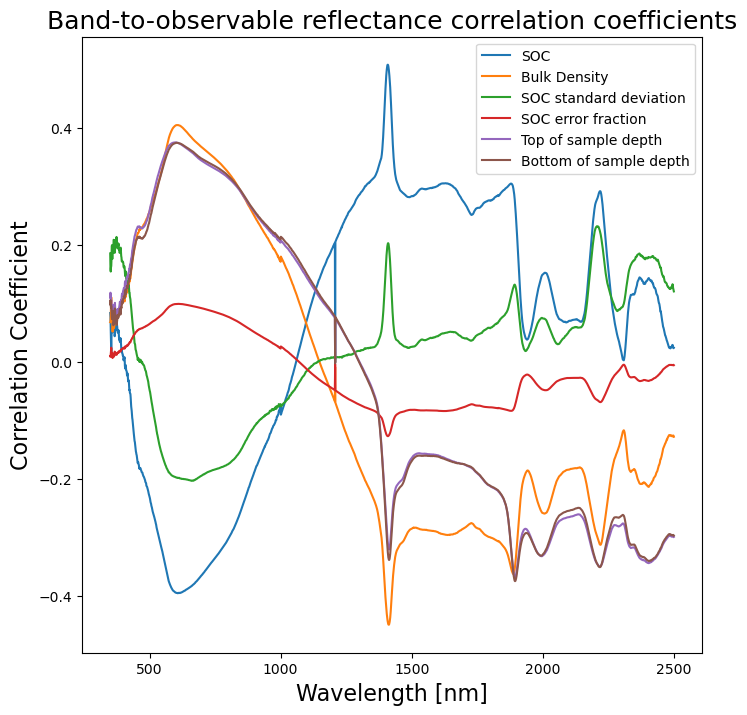

In [14]:
figbb, axbb = plt.subplots(figsize=(8, 8))
plt.plot(XF,np.corrcoef(I, sample_soc, rowvar = False)[:-1,-1],   label='SOC')
plt.plot(XF,np.corrcoef(I, sample_bd, rowvar = False)[:-1,-1],    label='Bulk Density')
plt.plot(XF,np.corrcoef(I, sample_socsd, rowvar = False)[:-1,-1], label='SOC standard deviation')
plt.plot(XF,np.corrcoef(I, sample_socsd/(sample_soc+0.0000001), rowvar = False)[:-1,-1], label='SOC error fraction')
plt.plot(XF,np.corrcoef(I, sample_top, rowvar = False)[:-1,-1],   label='Top of sample depth')
plt.plot(XF,np.corrcoef(I, sample_bot, rowvar = False)[:-1,-1],   label='Bottom of sample depth')


plt.ylabel('Correlation Coefficient',fontsize=16)
plt.xlabel('Wavelength [nm]',fontsize=16)

axbb.set_title('Band-to-observable reflectance correlation coefficients', fontsize=18)
axbb.legend()

plt.show()

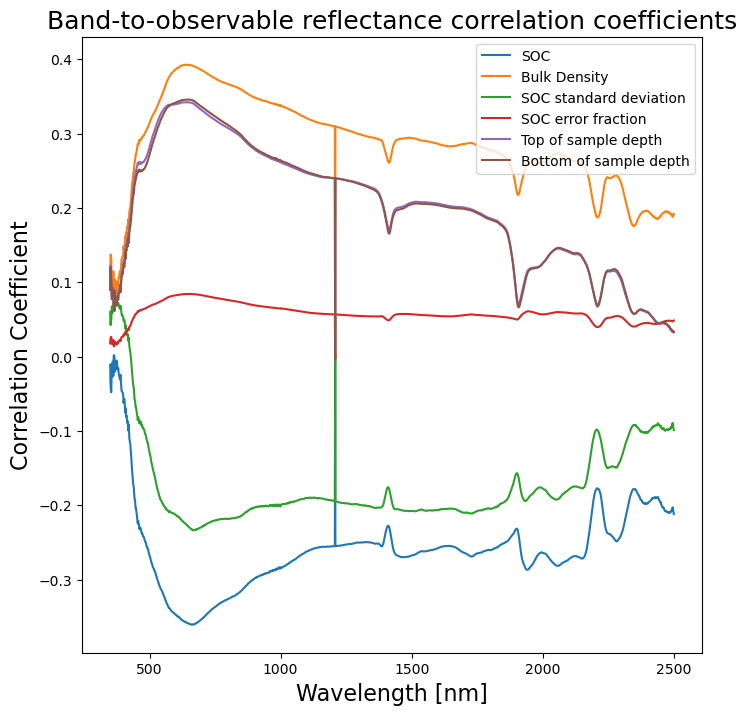

In [37]:
figbb, axbb = plt.subplots(figsize=(8, 8))
plt.plot(XF,np.corrcoef(data[1:,1:2152].astype('float32'), sample_soc, rowvar = False)[:-1,-1],   label='SOC')
plt.plot(XF,np.corrcoef(data[1:,1:2152].astype('float32'), sample_bd, rowvar = False)[:-1,-1],    label='Bulk Density')
plt.plot(XF,np.corrcoef(data[1:,1:2152].astype('float32'), sample_socsd, rowvar = False)[:-1,-1], label='SOC standard deviation')
plt.plot(XF,np.corrcoef(data[1:,1:2152].astype('float32'), sample_socsd/(sample_soc+0.0000001), rowvar = False)[:-1,-1], label='SOC error fraction')
plt.plot(XF,np.corrcoef(data[1:,1:2152].astype('float32'), sample_top, rowvar = False)[:-1,-1],   label='Top of sample depth')
plt.plot(XF,np.corrcoef(data[1:,1:2152].astype('float32'), sample_bot, rowvar = False)[:-1,-1],   label='Bottom of sample depth')


plt.ylabel('Correlation Coefficient',fontsize=16)
plt.xlabel('Wavelength [nm]',fontsize=16)

axbb.set_title('Band-to-observable reflectance correlation coefficients', fontsize=18)
axbb.legend()

plt.show()

### Correlations between soil variables independently of spectral lines

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
plt.imshow(np.corrcoef(I, sample_soc, rowvar = False),interpolation='none')

plt.ylabel('Band index [AU]',fontsize=16)
plt.xlabel('Band index [AU]',fontsize=16)

ax.set_title('Band-to-band reflectance correlation coefficients', fontsize=18)

plt.xlim([0,2150])
plt.ylim([0,2150])

plt.show()

### Identification of spectral troughs

### Principal component analysis / k-means clustering breaking down classes of spectra

#### Correlations between soil variables for each spectral class

#### Correlations between soil variables for each spectral class

#### Identification of spectral troughs for each spectral class

### Association of spectral troughs to endmembers

### Generation of seed endmember spectra

# Full fit to pseudodata